In [1]:
import os
import re
import json
import logging
import asyncio
import requests
import subprocess
import textstat
import asyncio
import nest_asyncio
import bert_score
import pandas as pd
import seaborn as sns
from pathlib import Path
from rouge import Rouge
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu


from llm_parser import DeepSeekAPI
from io_functions import run, popen, load_if_scraped, get_ollama_version

In [2]:
logging.basicConfig(level=logging.INFO, force=True)

In [3]:
ollama_server_process = popen("ollama serve")

ollama_server_process

<Popen: returncode: None args: ['ollama', 'serve']>

In [4]:
get_ollama_version()

'ollama version is 0.5.13'

In [5]:
process = run("ollama list")

print(process.stdout)

NAME               ID              SIZE      MODIFIED    
deepseek-r1:32b    38056bbcbb2d    19 GB     2 hours ago    
deepseek-r1:8b     28f8fd6cdc67    4.9 GB    4 days ago     



In [6]:
models = [line.strip() for line in process.stdout.split("\n") if line != ""][1:]

model_list = [model.split()[0] for model in models]
model_list

['deepseek-r1:32b', 'deepseek-r1:8b']

To prevent running a non-existing model:

In [7]:
model_name = model_list[0]
model_name

'deepseek-r1:32b'

In [8]:
# model_name = 'deepseek-r1:32b'

In [9]:
if model_name not in model_list:
    run(f"ollama pull {model_name}")

In [10]:
print(run(f"ollama show {model_name}").stdout)

  Model
    architecture        qwen2     
    parameters          32.8B     
    context length      131072    
    embedding length    5120      
    quantization        Q4_K_M    

  Parameters
    stop    "<｜begin▁of▁sentence｜>"    
    stop    "<｜end▁of▁sentence｜>"      
    stop    "<｜User｜>"                 
    stop    "<｜Assistant｜>"            

  License
    MIT License                    
    Copyright (c) 2023 DeepSeek    




In [11]:
def extract_model_info(text: str):
    embedding_match = re.search(r"embedding length\s+(\d+)", text)
    context_match = re.search(r"context length\s+(\d+)", text)

    embedding_length = int(embedding_match.group(1)) if embedding_match else None
    context_length = int(context_match.group(1)) if context_match else None

    return {"embedding_length": embedding_length, "context_length": context_length}


model_info = extract_model_info(run(f"ollama show {model_name}").stdout)
model_info

{'embedding_length': 5120, 'context_length': 131072}

In [12]:
model_process = popen(f"ollama run {model_name}")

In [13]:
print(run("ollama ps").stdout)

NAME               ID              SIZE     PROCESSOR    UNTIL              
deepseek-r1:32b    38056bbcbb2d    23 GB    100% GPU     4 minutes from now    



In [30]:
company_id = "126475"

In [31]:
df = load_if_scraped(company_id=company_id)

print(df.shape)
df.head()

INFO:root:successfully loaded local transcripts


,companyid,companyname,mostimportantdateutc,mostimportanttimeutc,headline,full_text,uuid,word_count,word_count_nltk
0,126475,SAP SE,2023-01-26,09:00:00,"SAP SE, Q4 2022 Earnings Call, Jan 26, 2023","Operator: Good morning, everyone. [indiscernib...",41d7bdc7-670c-4c7c-8564-5309895a54a9,18201,20735
1,126475,SAP SE,2023-01-26,13:00:00,"SAP SE, Q4 2022 Earnings Call, Jan 26, 2023","Operator: Ladies and gentlemen, thank you for ...",41d7bdc7-670c-4c7c-8564-5309895a54a9,17572,19907
2,126475,SAP SE,2023-04-21,12:00:00,"SAP SE, Q1 2023 Earnings Call, Apr 21, 2023","Operator: Ladies and gentlemen, thank you for ...",41d7bdc7-670c-4c7c-8564-5309895a54a9,33847,38982
3,126475,SAP SE,2023-05-11,08:00:00,SAP SE - Shareholder/Analyst Call,"Executives: Yes. Dear shareholders, of course,...",41d7bdc7-670c-4c7c-8564-5309895a54a9,62170,70217
4,126475,SAP SE,2023-05-16,17:00:00,SAP SE - Shareholder/Analyst Call,"Executives: Good morning, everyone, and welcom...",41d7bdc7-670c-4c7c-8564-5309895a54a9,44498,51235


In [32]:
api = DeepSeekAPI(model_name=model_name)

print(api)

DeepSeekAPI(model_name=deepseek-r1:32b, url=http://localhost:11434/api/generate, stream=False, timeout=30, max_retries=3)


In [33]:
nest_asyncio.apply()


async def batch_summary_generation(api: DeepSeekAPI, texts) -> list[str]:
    summaries = []
    for text in tqdm(texts):
        prompt = "summarize: " + text
        summary = await api.generate(prompt=prompt)
        summaries.append(summary)
    return summaries


summaries = await batch_summary_generation(api, df.full_text)

  0%|          | 0/22 [00:00<?, ?it/s]

DEBUG:root:Sending request to http://localhost:11434/api/generate with model deepseek-r1:32b
INFO:root:Response received from model deepseek-r1:32b
DEBUG:root:Sending request to http://localhost:11434/api/generate with model deepseek-r1:32b
INFO:root:Response received from model deepseek-r1:32b
DEBUG:root:Sending request to http://localhost:11434/api/generate with model deepseek-r1:32b
INFO:root:Response received from model deepseek-r1:32b
DEBUG:root:Sending request to http://localhost:11434/api/generate with model deepseek-r1:32b
INFO:root:Response received from model deepseek-r1:32b
DEBUG:root:Sending request to http://localhost:11434/api/generate with model deepseek-r1:32b
INFO:root:Response received from model deepseek-r1:32b
DEBUG:root:Sending request to http://localhost:11434/api/generate with model deepseek-r1:32b
INFO:root:Response received from model deepseek-r1:32b
DEBUG:root:Sending request to http://localhost:11434/api/generate with model deepseek-r1:32b
INFO:root:Response 

In [34]:
print(summaries[0])

**SAP Earnings Call Summary**

The SAP earnings call highlighted several key points:

1. **Cloud Growth**: SAP reported strong cloud growth, exceeding their 2025 targets. This success is attributed to a strategic shift towards the cloud, which offers predictable revenue streams and aligns with current market trends.

2. **Postponed Midterm Outlook**: The company postponed updating their midterm financial outlook to align with the arrival of their new CFO, Dominic, ensuring a cohesive approach to future planning.

3. **Qualtrics Sale**: SAP announced plans to sell Qualtrics, signaling a strategic focus on core areas and potential operational streamlining following previous acquisitions like SuccessFactors.

4. **Macroeconomic Challenges and Optimism**: While acknowledging difficulties in justifying high-capex on-premise investments due to economic pressures, SAP expressed cautious optimism about growth opportunities, particularly in digitizing sectors such as energy transition and mid-m

In [35]:
summary_column = f"{model_name}-summaries"
df[summary_column] = summaries

In [36]:
def evaluate_summary(row, model_name, type="baseline"):
    text_to_summarize = row.full_text
    summary = row[summary_column]
    uuid = row.uuid
    company_id = row.companyid
    company_name = row.companyname

    rouge_evaluator = Rouge()
    rouge_scores = rouge_evaluator.get_scores(summary, text_to_summarize)

    if isinstance(rouge_scores, list):
        rouge_scores = rouge_scores[0]

    reference_tokens = text_to_summarize.split()
    candidate_tokens = summary.split()
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)

    P, R, F1 = bert_score.score(
        [summary], [text_to_summarize], rescale_with_baseline=True, lang="en"
    )

    original_len = len(text_to_summarize.split())
    summary_len = len(summary.split())
    compression_ratio = summary_len / original_len if original_len > 0 else 0

    readability = textstat.flesch_reading_ease(summary)

    results = {}
    results["model_name"] = model_name
    results["uuid"] = uuid
    results["companyid"] = company_id
    results["companyname"] = company_name

    for metric, scores in rouge_scores.items():
        results[f"{metric}_r"] = scores["r"]
        results[f"{metric}_p"] = scores["p"]
        results[f"{metric}_f"] = scores["f"]

    results["bleu"] = bleu_score
    results["bert_precision"] = P.item()
    results["bert_recall"] = R.item()
    results["bert_f1"] = F1.item()
    results["compression_ratio"] = compression_ratio
    results["readability"] = readability

    return pd.DataFrame([results])

In [37]:
evaluation_results = pd.DataFrame()

for _, row in tqdm(df.iterrows()):
    evaluation_result = evaluate_summary(row, model_name)
    evaluation_results = pd.concat(
        [evaluation_results, evaluation_result], ignore_index=True
    )

evaluation_results.head()

0it [00:00, ?it/s]

/workspace/persistent/ragsum/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/workspace/persistent/ragsum/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
DEBUG:urllib3.connectionpool:Resetting dropped connection: huggingface.co
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-large/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-large/resol

,model_name,uuid,companyid,companyname,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f,bleu,bert_precision,bert_recall,bert_f1,compression_ratio,readability
0,deepseek-r1:32b,41d7bdc7-670c-4c7c-8564-5309895a54a9,126475,SAP SE,0.051941,0.541667,0.094792,0.003331,0.102439,0.006452,0.050228,0.523810,0.091667,1.973006e-192,-0.130163,-0.287014,-0.207928,0.011428,16.52
1,deepseek-r1:32b,41d7bdc7-670c-4c7c-8564-5309895a54a9,126475,SAP SE,0.070810,0.631818,0.127348,0.006821,0.143791,0.013024,0.067244,0.600000,0.120934,1.882131e-25,-0.206937,-0.277761,-0.240599,0.018097,29.55
2,deepseek-r1:32b,41d7bdc7-670c-4c7c-8564-5309895a54a9,126475,SAP SE,0.052454,0.539604,0.095614,0.005284,0.121951,0.010129,0.049567,0.509901,0.090351,4.082549e-128,-0.219595,-0.323773,-0.270202,0.008657,11.41
3,deepseek-r1:32b,41d7bdc7-670c-4c7c-8564-5309895a54a9,126475,SAP SE,0.016934,0.655462,0.033016,0.001545,0.213333,0.003068,0.016717,0.647059,0.032593,9.536447e-178,-0.267085,-0.304325,-0.283692,0.002461,16.59
4,deepseek-r1:32b,41d7bdc7-670c-4c7c-8564-5309895a54a9,126475,SAP SE,0.033181,0.681250,0.063280,0.002569,0.179612,0.005065,0.032268,0.662500,0.061538,8.780909e-92,-0.180356,-0.249763,-0.213342,0.004809,18.65


In [38]:
csv_filename = Path("..") / "data" / "evaluation_results.csv"

if os.path.exists(csv_filename):
    existing_df = pd.read_csv(csv_filename)
    if (
        (existing_df.model_name == model_name) & (existing_df.companyid == company_id)
    ).any():
        logging.info(
            f"model {model_name} and {company_id} combination already exists in {csv_filename}. no new row added."
        )
        updated_df = existing_df
    else:
        updated_df = pd.concat([existing_df, evaluation_results], ignore_index=True)
        logging.info(
            f"model {model_name} not found. appending new row to {csv_filename}."
        )
else:
    updated_df = evaluation_results
    logging.info(f"{csv_filename} not found. creating new file.")

updated_df.to_csv(csv_filename, index=False)
logging.info(f"results saved to {csv_filename}")

INFO:root:model deepseek-r1:32b not found. appending new row to ../data/evaluation_results.csv.
INFO:root:results saved to ../data/evaluation_results.csv


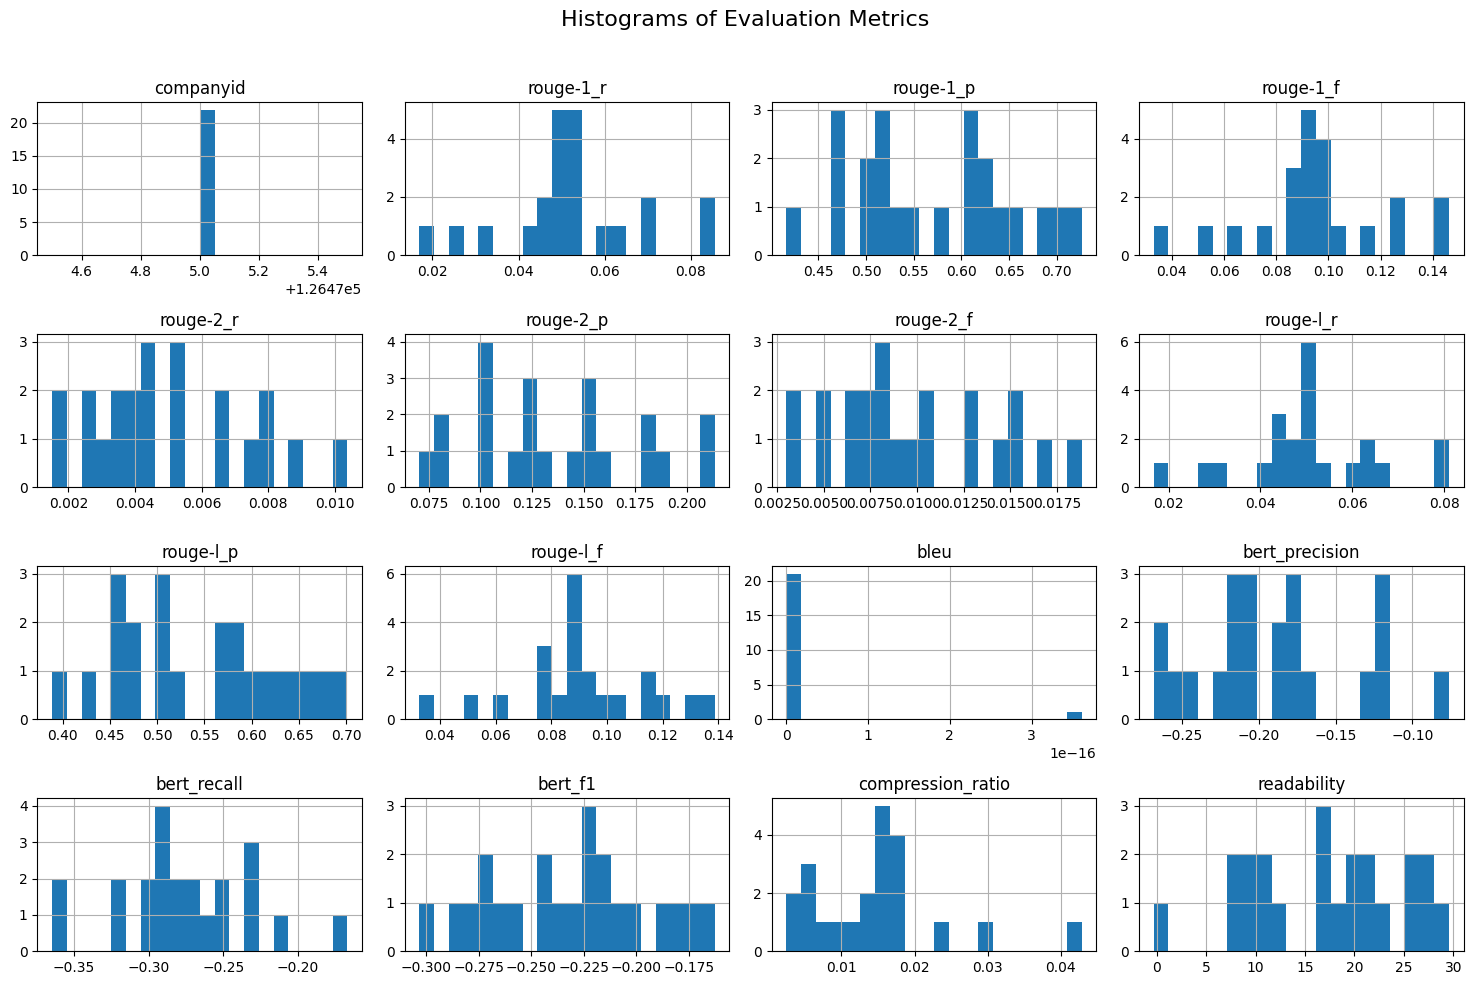

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f2848dcf940>


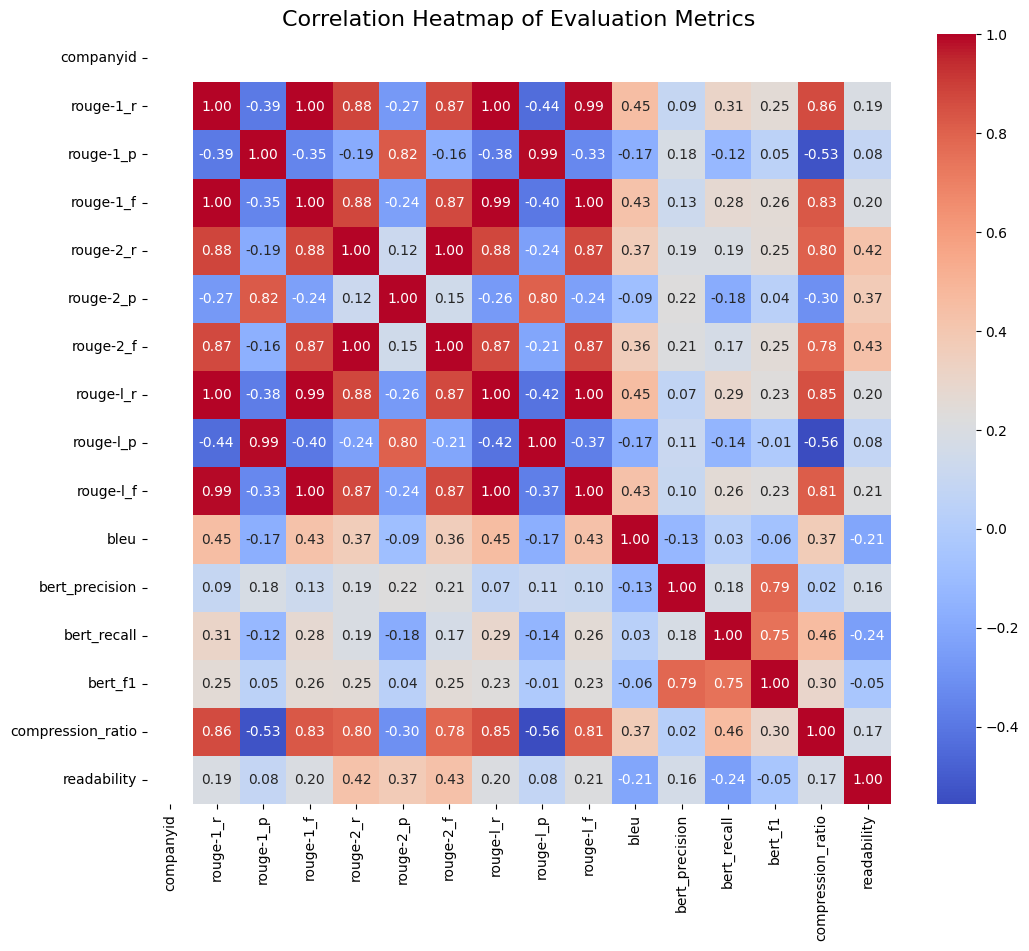

In [39]:
def visualize_results(df):
    """
    Visualizes evaluation metrics stored in a DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing evaluation results with numeric metric columns.

    This function produces:
    - Histograms for each numeric metric.
    - A correlation heatmap of the numeric metrics.
    """
    numeric_cols = df.select_dtypes(include="number").columns.tolist()

    df[numeric_cols].hist(bins=20, figsize=(15, 10))
    plt.suptitle("Histograms of Evaluation Metrics", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    plt.figure(figsize=(12, 10))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of Evaluation Metrics", fontsize=16)
    plt.show()


visualize_results(evaluation_results)

In [40]:
df.to_csv(
    Path("..")
    / "data"
    / "summaries"
    / f"{company_id}_{model_name}.csv".replace("/", "-"),
    sep="\t",
    index=False,
    quoting=1,
    escapechar="\\",
    doublequote=True,
    quotechar='"',
    lineterminator="\n",
)

In [42]:
print(df.full_text[0][:2000])

Operator: Good morning, everyone. [indiscernible]. I'm Oliver Roll. I'm SAP's Chief Comps Officer. Thank you so much for being with us today, either in the room or for those of you joining via our streaming platform. For those of you in the room, I think some of you were here a few years ago, it's so nice to be in person again. So thank you again for joining us. In a moment, we'll have comments from our CEO, Christian Klein; from our CFO, Luka Mucic. A couple of things before we start. One, please note that this session is being recorded. And then secondly, please note that all figures are non-IFRS and all growth rates are non-IFRS at constant currency, unless we state otherwise. 
Once we finish the remarks, we'll hand it over to you for questions. [Operator Instructions] So with that, Christian, hello, welcome, and over to you.
Executives: Thank you, Oliver. First of all, I would like to wish everyone a happy and a healthy new year. And indeed, Oliver was this week, 2 times in the can

In [44]:
print(df[summary_column][0])

**SAP Earnings Call Summary**

The SAP earnings call highlighted several key points:

1. **Cloud Growth**: SAP reported strong cloud growth, exceeding their 2025 targets. This success is attributed to a strategic shift towards the cloud, which offers predictable revenue streams and aligns with current market trends.

2. **Postponed Midterm Outlook**: The company postponed updating their midterm financial outlook to align with the arrival of their new CFO, Dominic, ensuring a cohesive approach to future planning.

3. **Qualtrics Sale**: SAP announced plans to sell Qualtrics, signaling a strategic focus on core areas and potential operational streamlining following previous acquisitions like SuccessFactors.

4. **Macroeconomic Challenges and Optimism**: While acknowledging difficulties in justifying high-capex on-premise investments due to economic pressures, SAP expressed cautious optimism about growth opportunities, particularly in digitizing sectors such as energy transition and mid-m

In [45]:
model_process.terminate()
ollama_server_process.terminate()